# Tutorial 4: Fixed Connection Count Structures - Biologically Realistic Network Topology

In biological neural networks, each neuron typically has a **fixed number of synaptic connections**. For example:
- Cortical pyramidal neurons: approximately 10,000 dendritic spines (receiving connections)
- Cerebellar Purkinje cells: approximately 200,000 dendritic spines
- The number of output connections per neuron is also relatively fixed

BrainEvent provides two fixed connection count structures to simulate these biological characteristics:
- **FixedPostNumConn**: Each **presynaptic** neuron has a fixed number of output connections
- **FixedPreNumConn**: Each **postsynaptic** neuron has a fixed number of input connections

## Contents
1. Biological significance of fixed connection counts
2. FixedPostNumConn - Fixed output connections
3. FixedPreNumConn - Fixed input connections
4. Creation and usage
5. Using with BinaryArray
6. Practice: Biologically realistic cortical network
7. Performance and memory analysis

## 1. Biological significance of fixed connection counts

### Why do we need fixed connection counts?

In biological neural networks:
- 🧠 **Energy constraints**: The number of synapses per neuron is limited by metabolic costs
- 🧠 **Space constraints**: Dendritic physical space is limited
- 🧠 **Functional requirements**: Different neuron types have specific connection patterns

### Comparison with other structures

| Data Structure | Connection Method | Use Cases |
|---------|---------|----------|
| **CSR/COO** | Arbitrary sparse connections | General sparse matrices |
| **JIT connections** | Random probability connections | Ultra-large-scale networks |
| **FixedPostNumConn** | Fixed number of outputs per presynaptic neuron | Biologically realistic models |
| **FixedPreNumConn** | Fixed number of inputs per postsynaptic neuron | Specific topologies |

### Core advantages
- ✅ **Biologically realistic**: Matches real neural network characteristics
- ✅ **Regular memory**: Regular data structures, easy to optimize
- ✅ **Efficient computation**: Fixed-size operations, easy to parallelize
- ✅ **Strong controllability**: Precisely control connection count per neuron

In [10]:
import brainevent
import brainstate
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

print(f"BrainEvent version: {brainevent.__version__}")


BrainEvent version: 0.0.4


## 2. FixedPostNumConn - Fixed output connection count

**FixedPostNumConn** represents that each **presynaptic neuron** sends out a fixed number of output connections.

### Data structure
```python
data:    [num_pre, num_conn]  # weight matrix
indices: [num_pre, num_conn]  # which postsynaptic neurons each presynaptic neuron connects to
```

### Creation method

In [11]:
# Example: 100 presynaptic neurons -> 50 postsynaptic neurons
# Each presynaptic neuron connects to 10 postsynaptic neurons

n_pre = 100
n_post = 50
num_conn_per_pre = 10  # Number of output connections per presynaptic neuron

# Randomly generate connection indices and weights
brainstate.random.seed(42)

# Randomly select 10 postsynaptic neurons for each presynaptic neuron
indices = brainstate.random.randint(0, n_post, size=(n_pre, num_conn_per_pre))

# Generate random weights
weights = brainstate.random.normal(size=(n_pre, num_conn_per_pre)) * 0.1

# Create FixedPostNumConn structure
fixed_post = brainevent.FixedPostNumConn(
    (weights, indices),
    shape=(n_pre, n_post)
)

print("FixedPostNumConn information:")
print(f"  shape: {fixed_post.shape}")
print(f"  weight array shape: {fixed_post.data.shape}")
print(f"  indices array shape: {fixed_post.indices.shape}")
print(f"  total connections: {n_pre * num_conn_per_pre}")
print(f"\nExample connections:")
print(f"  neuron 0 connects to: {indices[0]}")
print(f"  corresponding weights: {weights[0]}")

FixedPostNumConn information:
  shape: (100, 50)
  weight array shape: (100, 10)
  indices array shape: (100, 10)
  total connections: 1000

Example connections:
  neuron 0 connects to: [35 22  4 22 35  4 41 38  6 25]
  corresponding weights: [-0.02108904 -0.13627948 -0.00450038 -0.11536395  0.19141139 -0.04770131
  0.06478766  0.06747401  0.29508728 -0.08744793]


### Visualizing connection patterns

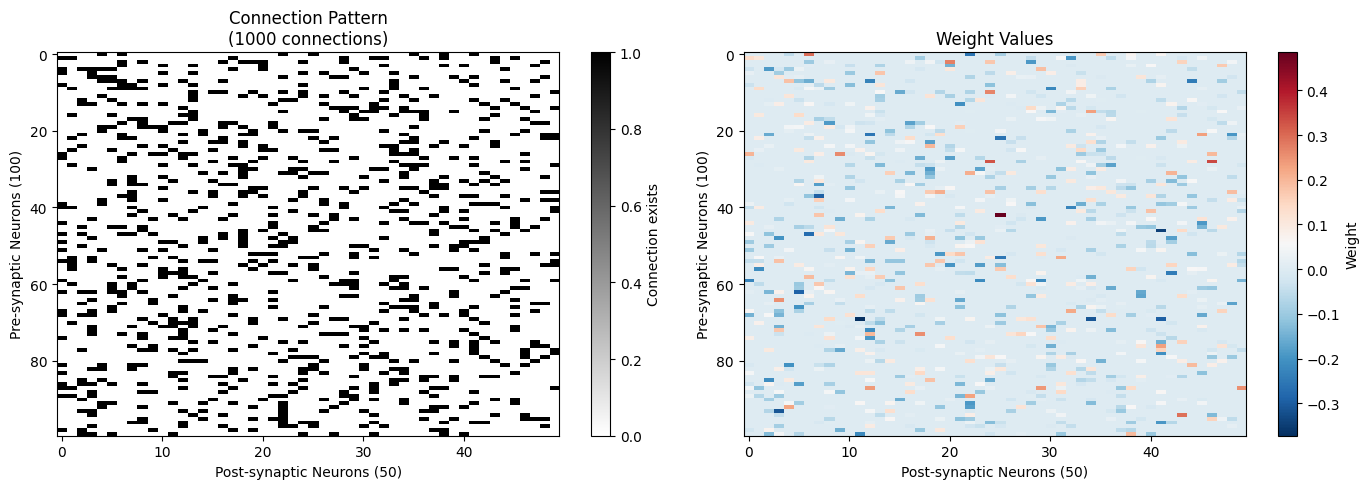


Input connections per postsynaptic neuron:
  Minimum: 12
  Maximum: 29
  Average: 18.4
  Standard deviation: 3.7


In [12]:
# Convert to dense matrix for visualization
dense_matrix = fixed_post.todense()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Connection pattern
im1 = axes[0].imshow(np.array(dense_matrix != 0), aspect='auto', cmap='binary', interpolation='nearest')
axes[0].set_title(f'Connection Pattern\n({n_pre * num_conn_per_pre} connections)', fontsize=12)
axes[0].set_xlabel('Post-synaptic Neurons (50)', fontsize=10)
axes[0].set_ylabel('Pre-synaptic Neurons (100)', fontsize=10)
plt.colorbar(im1, ax=axes[0], label='Connection exists')

# Weight distribution
im2 = axes[1].imshow(np.array(dense_matrix), aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[1].set_title('Weight Values', fontsize=12)
axes[1].set_xlabel('Post-synaptic Neurons (50)', fontsize=10)
axes[1].set_ylabel('Pre-synaptic Neurons (100)', fontsize=10)
plt.colorbar(im2, ax=axes[1], label='Weight')

plt.tight_layout()
plt.show()

# Statistics of connections received by each postsynaptic neuron
post_conn_counts = (dense_matrix != 0).sum(axis=0)
print(f"\nInput connections per postsynaptic neuron:")
print(f"  Minimum: {post_conn_counts.min()}")
print(f"  Maximum: {post_conn_counts.max()}")
print(f"  Average: {post_conn_counts.mean():.1f}")
print(f"  Standard deviation: {post_conn_counts.std():.1f}")

## 3. FixedPreNumConn - Fixed input connection count

**FixedPreNumConn** represents that each **postsynaptic neuron** receives a fixed number of input connections.

### Data structure
```python
data:    [num_post, num_conn]  # weight matrix
indices: [num_post, num_conn]  # which presynaptic neurons each postsynaptic neuron receives input from
```

In [13]:
# Example: 200 presynaptic neurons -> 100 postsynaptic neurons
# Each postsynaptic neuron receives 15 input connections

n_pre = 200
n_post = 100
num_conn_per_post = 15  # Number of input connections per postsynaptic neuron

brainstate.random.seed(123)

# Randomly select 15 presynaptic neurons for each postsynaptic neuron
indices = brainstate.random.randint(0, n_pre, size=(n_post, num_conn_per_post))

# Generate random weights
weights = brainstate.random.normal(size=(n_post, num_conn_per_post)) * 0.05

# Create FixedPreNumConn structure
fixed_pre = brainevent.FixedPreNumConn(
    (weights, indices),
    shape=(n_pre, n_post)
)

print("FixedPreNumConn information:")
print(f"  shape: {fixed_pre.shape}")
print(f"  weight array shape: {fixed_pre.data.shape}")
print(f"  indices array shape: {fixed_pre.indices.shape}")
print(f"  total connections: {n_post * num_conn_per_post}")
print(f"\nExample connections:")
print(f"  neuron 0 receives from: {indices[0]}")
print(f"  corresponding weights: {weights[0]}")

FixedPreNumConn information:
  shape: (200, 100)
  weight array shape: (100, 15)
  indices array shape: (100, 15)
  total connections: 1500

Example connections:
  neuron 0 receives from: [ 16  45  37  61  50  72  47 197 140 186 182 105   7 100  30]
  corresponding weights: [-0.09292667 -0.02407313 -0.00171479 -0.17258634  0.01208776 -0.02844428
 -0.0558086   0.01732394 -0.05132271 -0.00761002  0.03108218  0.05758841
  0.10048639  0.0313901  -0.02753625]


## 4. Using with BinaryArray

When combined with BinaryArray, fixed connection count structures can efficiently implement event-driven synaptic transmission.

In [14]:
# Using FixedPostNumConn for forward propagation
print("=" * 60)
print("Testing FixedPostNumConn")
print("=" * 60)

# Generate input spikes (must match fixed_post's input dimension: 100)
brainstate.random.seed(999)
spikes_bool = brainstate.random.bernoulli(0.1, size=(100,))  # Using n_pre=100
spikes = brainevent.BinaryArray(spikes_bool)

print(f"\nInput spikes: {spikes.sum()} / 100 fired")

# Event-driven matrix multiplication
output = spikes @ fixed_post

print(f"\nOutput statistics:")
print(f"  shape: {output.shape}")
print(f"  maximum value: {output.max():.4f}")
print(f"  minimum value: {output.min():.4f}")
print(f"  average value: {output.mean():.4f}")
print(f"  non-zero outputs: {jnp.sum(output != 0)}")

Testing FixedPostNumConn

Input spikes: 8 / 100 fired

Output statistics:
  shape: (50,)
  maximum value: 0.4428
  minimum value: -0.2197
  average value: 0.0296
  non-zero outputs: 39


In [15]:
# Using FixedPreNumConn for forward propagation
print("=" * 60)
print("Testing FixedPreNumConn")
print("=" * 60)

# Generate input spikes (matching fixed_pre's size)
brainstate.random.seed(888)
spikes_bool = brainstate.random.bernoulli(0.05, size=(200,))
spikes = brainevent.BinaryArray(spikes_bool)

print(f"\nInput spikes: {spikes.sum()} / 200 fired")

# Event-driven matrix multiplication
output = spikes @ fixed_pre

print(f"\nOutput statistics:")
print(f"  shape: {output.shape}")
print(f"  maximum value: {output.max():.4f}")
print(f"  minimum value: {output.min():.4f}")
print(f"  average value: {output.mean():.4f}")
print(f"  non-zero outputs: {jnp.sum(output != 0)}")

Testing FixedPreNumConn

Input spikes: 7 / 200 fired

Output statistics:
  shape: (100,)
  maximum value: 0.0901
  minimum value: -0.1044
  average value: 0.0005
  non-zero outputs: 41


## 5. Practice: Biologically realistic cortical network

Let's build a network simulating the cerebral cortex, using fixed connection counts to reflect real neuron characteristics.

In [17]:
class CorticalNetwork:
    """Cortical network simulation using fixed connection count structures"""

    def __init__(self,
                 n_exc=800,      # Number of excitatory neurons (80%)
                 n_inh=200,      # Number of inhibitory neurons (20%)
                 exc_fanout=50,  # Output connections per excitatory neuron
                 inh_fanout=30,  # Output connections per inhibitory neuron
                 seed=0):
        """
        Create a biologically realistic cortical network

        References:
        - Excitatory neurons account for approximately 80% in cortex, inhibitory ~20%
        - Each pyramidal neuron has approximately thousands of synaptic connections
        """
        self.n_exc = n_exc
        self.n_inh = n_inh
        self.n_total = n_exc + n_inh

        brainstate.random.seed(seed)

        # Excitatory -> Excitatory connections
        exc_to_exc_idx = brainstate.random.randint(0, n_exc, size=(n_exc, exc_fanout))
        exc_to_exc_w = brainstate.random.normal(size=(n_exc, exc_fanout)) * 0.05
        self.w_ee = brainevent.FixedPostNumConn((exc_to_exc_w, exc_to_exc_idx), shape=(n_exc, n_exc))

        # Excitatory -> Inhibitory connections
        exc_to_inh_idx = brainstate.random.randint(0, n_inh, size=(n_exc, exc_fanout // 2))
        exc_to_inh_w = brainstate.random.normal(size=(n_exc, exc_fanout // 2)) * 0.08
        self.w_ei = brainevent.FixedPostNumConn((exc_to_inh_w, exc_to_inh_idx), shape=(n_exc, n_inh))

        # Inhibitory -> Excitatory connections (negative weights)
        inh_to_exc_idx = brainstate.random.randint(0, n_exc, size=(n_inh, inh_fanout))
        inh_to_exc_w = -brainstate.random.normal(size=(n_inh, inh_fanout)) * 0.15  # Negative weights
        self.w_ie = brainevent.FixedPostNumConn((inh_to_exc_w, inh_to_exc_idx), shape=(n_inh, n_exc))

        print(f"Cortical network structure:")
        print(f"  Total neurons: {self.n_total}")
        print(f"  Excitatory: {n_exc} ({n_exc/self.n_total*100:.0f}%)")
        print(f"  Inhibitory: {n_inh} ({n_inh/self.n_total*100:.0f}%)")
        print(f"\nConnection statistics:")
        print(f"  E->E: {n_exc * exc_fanout:,} connections")
        print(f"  E->I: {n_exc * exc_fanout // 2:,} connections")
        print(f"  I->E: {n_inh * inh_fanout:,} connections")
        print(f"  Total connections: {n_exc * exc_fanout + n_exc * exc_fanout // 2 + n_inh * inh_fanout:,}")

    def forward(self, exc_spikes, inh_spikes):
        """Network forward propagation"""
        # Input received by excitatory neurons
        exc_input_from_exc = exc_spikes @ self.w_ee
        exc_input_from_inh = inh_spikes @ self.w_ie
        exc_total_input = exc_input_from_exc + exc_input_from_inh

        # Input received by inhibitory neurons
        inh_input = exc_spikes @ self.w_ei

        return exc_total_input, inh_input

# Create cortical network
cortical_net = CorticalNetwork(
    n_exc=800,
    n_inh=200,
    exc_fanout=50,
    inh_fanout=30,
    seed=2024
)

Cortical network structure:
  Total neurons: 1000
  Excitatory: 800 (80%)
  Inhibitory: 200 (20%)

Connection statistics:
  E->E: 40,000 connections
  E->I: 20,000 connections
  I->E: 6,000 connections
  Total connections: 66,000


Simulating network dynamics...



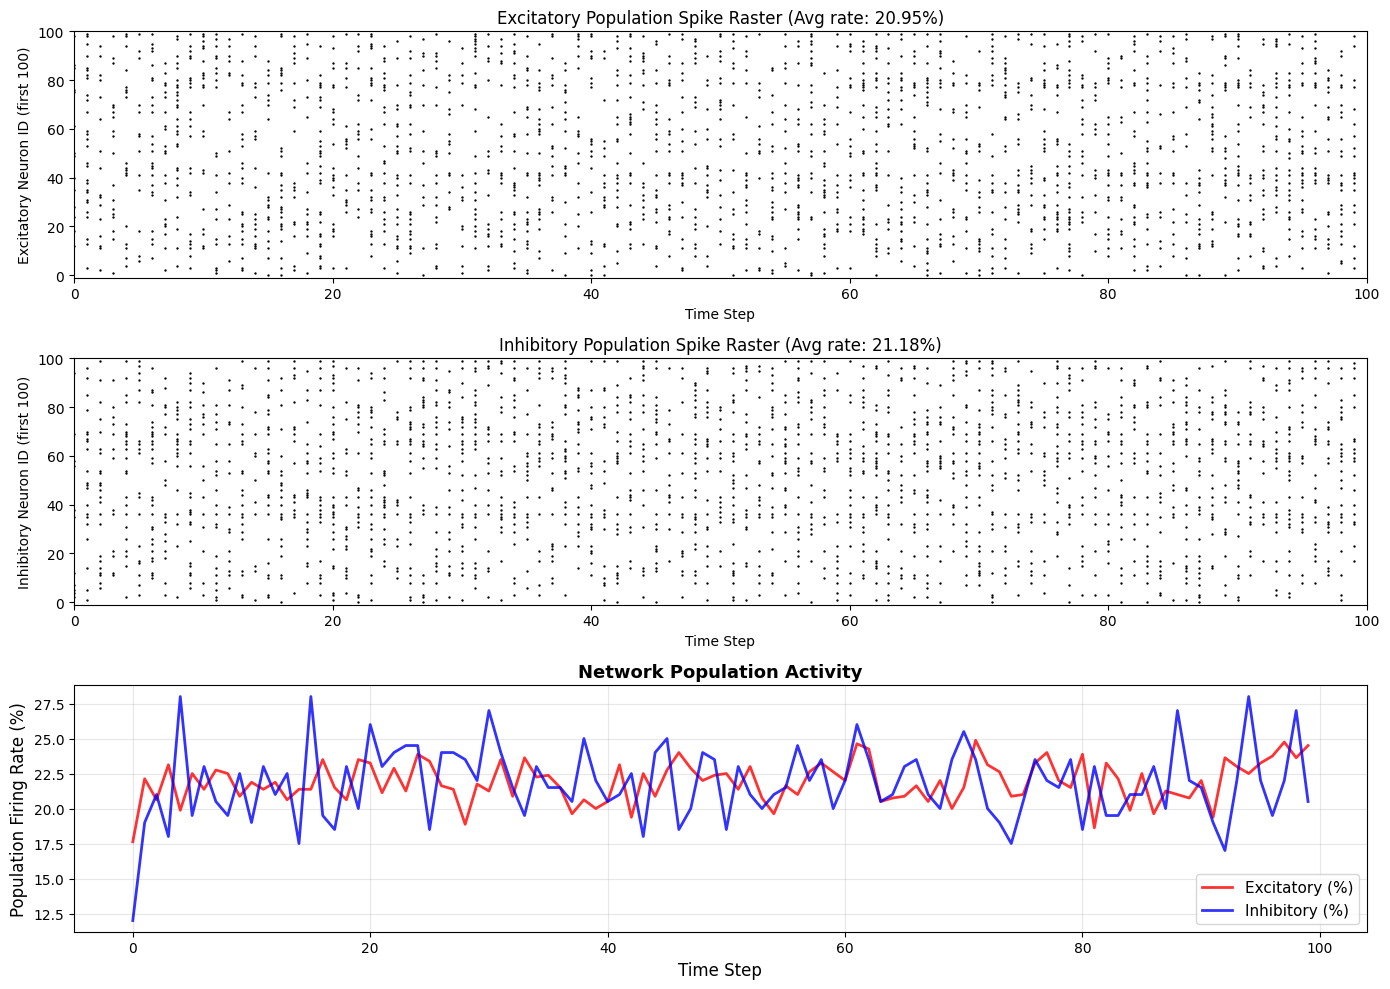


Simulation statistics:
  Average excitatory firing rate: 21.90%
  Average inhibitory firing rate: 21.80%
  Excitatory firing range: [141, 199]
  Inhibitory firing range: [24, 56]
  Excitatory first 100 neurons total spikes: 2095
  Inhibitory first 100 neurons total spikes: 2118

Note: Thresholds adjusted to generate realistic activity levels:
  - Excitatory threshold: 0.3 (was 1.0)
  - Inhibitory threshold: 0.25 (was 0.8)
  - External input strength increased to 0.3 (was 0.2)


In [18]:
# Simulate network dynamics
import braintools

n_steps = 100
spike_threshold_exc = 0.3  # Lower threshold for excitatory neurons
spike_threshold_inh = 0.25  # Lower threshold for inhibitory neurons

# Initialize
brainstate.random.seed(0)
exc_spikes = brainevent.BinaryArray(brainstate.random.bernoulli(0.1, size=(800,)))
inh_spikes = brainevent.BinaryArray(jnp.zeros(200, dtype=bool))

# Record history (complete spike matrix for raster plots)
exc_spike_matrix = []  # Record first 100 excitatory neurons
inh_spike_matrix = []  # Record first 100 inhibitory neurons
exc_spike_counts = []  # Record total spike counts
inh_spike_counts = []  # Record total spike counts

print("Simulating network dynamics...\n")

for step in range(n_steps):
    # Forward propagation
    exc_input, inh_input = cortical_net.forward(exc_spikes, inh_spikes)

    # Add external input (simulating background activity) - increased strength
    external_input = brainstate.random.normal(size=(800,)) * 0.3
    exc_input = exc_input + external_input

    # Generate spikes (simple threshold model)
    exc_spikes = brainevent.BinaryArray(exc_input > spike_threshold_exc)
    inh_spikes = brainevent.BinaryArray(inh_input > spike_threshold_inh)

    # Record spike counts
    exc_spike_counts.append(int(exc_spikes.sum()))
    inh_spike_counts.append(int(inh_spikes.sum()))

    # Record spike matrix (first 100 neurons)
    exc_spike_matrix.append(np.array(exc_spikes.value[:100], dtype=int))
    inh_spike_matrix.append(np.array(inh_spikes.value[:100], dtype=int))

# Convert to arrays
exc_spike_matrix = np.array(exc_spike_matrix)  # (100, 100)
inh_spike_matrix = np.array(inh_spike_matrix)  # (100, 100)
ts = np.arange(n_steps)

# Visualize network activity using braintools
fig = plt.figure(figsize=(14, 10))

# Subplot 1: Excitatory neuron raster plot
ax1 = plt.subplot(3, 1, 1)
braintools.visualize.raster_plot(
    ts,
    exc_spike_matrix,
    markersize=2,
    ax=ax1,
    xlim=(0, n_steps),
    ylim=(-1, 100),
    xlabel='Time Step',
    ylabel='Excitatory Neuron ID (first 100)',
    title=f'Excitatory Population Spike Raster (Avg rate: {exc_spike_matrix.mean():.2%})',
    show=False
)

# Subplot 2: Inhibitory neuron raster plot
ax2 = plt.subplot(3, 1, 2)
braintools.visualize.raster_plot(
    ts,
    inh_spike_matrix,
    markersize=2,
    ax=ax2,
    xlim=(0, n_steps),
    ylim=(-1, 100),
    xlabel='Time Step',
    ylabel='Inhibitory Neuron ID (first 100)',
    title=f'Inhibitory Population Spike Raster (Avg rate: {inh_spike_matrix.mean():.2%})',
    show=False
)

# Subplot 3: Population firing rates
ax3 = plt.subplot(3, 1, 3)
exc_rates = np.array(exc_spike_counts) / 800 * 100
inh_rates = np.array(inh_spike_counts) / 200 * 100
ax3.plot(exc_rates, label='Excitatory (%)', color='red', linewidth=2, alpha=0.8)
ax3.plot(inh_rates, label='Inhibitory (%)', color='blue', linewidth=2, alpha=0.8)
ax3.set_xlabel('Time Step', fontsize=12)
ax3.set_ylabel('Population Firing Rate (%)', fontsize=12)
ax3.set_title('Network Population Activity', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSimulation statistics:")
print(f"  Average excitatory firing rate: {np.mean(exc_rates):.2f}%")
print(f"  Average inhibitory firing rate: {np.mean(inh_rates):.2f}%")
print(f"  Excitatory firing range: [{min(exc_spike_counts)}, {max(exc_spike_counts)}]")
print(f"  Inhibitory firing range: [{min(inh_spike_counts)}, {max(inh_spike_counts)}]")
print(f"  Excitatory first 100 neurons total spikes: {exc_spike_matrix.sum()}")
print(f"  Inhibitory first 100 neurons total spikes: {inh_spike_matrix.sum()}")

print(f"\nNote: Thresholds adjusted to generate realistic activity levels:")
print(f"  - Excitatory threshold: {spike_threshold_exc} (was 1.0)")
print(f"  - Inhibitory threshold: {spike_threshold_inh} (was 0.8)")
print(f"  - External input strength increased to 0.3 (was 0.2)")

## 6. Performance and memory analysis

In [20]:
import time

# Compare performance of different data structures
n_pre = 5000
n_post = 5000
num_conn = 50  # Each presynaptic neuron connects to 50 postsynaptic neurons

print(f"Performance test configuration: {n_pre} -> {n_post}, {num_conn} connections per neuron\n")

# 1. FixedPostNumConn
brainstate.random.seed(0)
indices_fixed = brainstate.random.randint(0, n_post, size=(n_pre, num_conn))
weights_fixed = brainstate.random.normal(size=(n_pre, num_conn)) * 0.1
fixed_conn = brainevent.FixedPostNumConn((weights_fixed, indices_fixed), shape=(n_pre, n_post))

# 2. COO (for comparison - not using CSR because to_csr() is not available)
row_indices = jnp.repeat(jnp.arange(n_pre), num_conn)
col_indices = indices_fixed.flatten()
data = weights_fixed.flatten()
coo_conn = brainevent.COO((data, row_indices, col_indices), shape=(n_pre, n_post))

# Generate input
spikes = brainevent.BinaryArray(brainstate.random.bernoulli(0.02, size=(n_pre,)))

print(f"Input spikes: {spikes.sum()} / {n_pre}\n")

# Memory comparison
fixed_memory = fixed_conn.data.nbytes + fixed_conn.indices.nbytes
coo_memory = coo_conn.data.nbytes + coo_conn.row.nbytes + coo_conn.col.nbytes

print("Memory usage:")
print(f"  FixedPostNumConn: {fixed_memory / 1024 / 1024:.2f} MB")
print(f"  COO:              {coo_memory / 1024 / 1024:.2f} MB")
print(f"  Ratio:            {coo_memory / fixed_memory:.2f}x\n")

# Warm-up
_ = jax.block_until_ready(spikes @ fixed_conn)
_ = jax.block_until_ready(spikes @ coo_conn)

n_trials = 100

# FixedPostNumConn performance
start = time.time()
for _ in range(n_trials):
    result_fixed = jax.block_until_ready(spikes @ fixed_conn)
fixed_time = (time.time() - start) / n_trials

# COO performance
start = time.time()
for _ in range(n_trials):
    result_coo = jax.block_until_ready(spikes @ coo_conn)
coo_time = (time.time() - start) / n_trials

print("Computation performance (average time):")
print(f"  FixedPostNumConn: {fixed_time*1000:.3f} ms")
print(f"  COO:              {coo_time*1000:.3f} ms")

# Avoid division by zero error
if fixed_time > 0:
    print(f"  Speed ratio:      {coo_time/fixed_time:.2f}x")
else:
    print(f"  Speed ratio:      FixedPostNumConn is too fast to measure accurately (< {1/n_trials*1000:.3f} ms)")

print(f"\nResult consistency: {jnp.allclose(result_fixed, result_coo, atol=1e-5)}")

Performance test configuration: 5000 -> 5000, 50 connections per neuron

Input spikes: 88 / 5000

Memory usage:
  FixedPostNumConn: 1.91 MB
  COO:              2.86 MB
  Ratio:            1.50x

Computation performance (average time):
  FixedPostNumConn: 0.000 ms
  COO:              0.000 ms
  Speed ratio:      FixedPostNumConn is too fast to measure accurately (< 10.000 ms)

Result consistency: True


## 7. Usage recommendations

### FixedPostNumConn vs FixedPreNumConn?

**Use FixedPostNumConn when:**
- ✅ Each presynaptic neuron sends out a fixed number of connections
- ✅ Row-wise access is needed (standard forward propagation)
- ✅ Most spiking neural network applications

**Use FixedPreNumConn when:**
- ✅ Each postsynaptic neuron receives a fixed number of connections
- ✅ Column-wise access is needed
- ✅ Specific biological constraints (e.g., fixed dendritic spine count)

### Selection among other structures

- **Small-scale, arbitrary connections**: Use **CSR/COO**
- **Ultra-large-scale, random connections**: Use **JIT connections**
- **Biologically realistic, fixed connection counts**: Use **FixedPostNumConn/FixedPreNumConn**
- **Dense connections**: Use **regular arrays**

## 8. Summary

In this tutorial, we learned:

1. ✅ **Biological significance**: Fixed connection counts match real neural network characteristics
2. ✅ **FixedPostNumConn**: Fixed output connections per presynaptic neuron
3. ✅ **FixedPreNumConn**: Fixed input connections per postsynaptic neuron
4. ✅ **Creation and usage**: How to build fixed connection count structures
5. ✅ **Using with BinaryArray**: Efficient event-driven computation
6. ✅ **Practical application**: Building biologically realistic cortical networks
7. ✅ **Performance analysis**: Comparison with other data structures

### Key takeaways
- 🔑 **Fixed connection counts = Biological realism**
- 🔑 **Regular data structures = Efficient computation**
- 🔑 **Suitable for medium-scale biological modeling**

## Next Steps

In the next tutorial, we will learn:
- 📚 **Tutorial 5**: Synaptic plasticity modeling - STDP, short-term plasticity
- Learn how to implement learning and memory in BrainEvent
- Build neural networks with adaptive capabilities